In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.applications import EfficientNetV2B1
from keras.callbacks import EarlyStopping

In [2]:
non_demented = []
very_mild_demented = []
mild_demented = []
moderate_demented = []

for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Non Demented'):
    for filename in filenames:
        non_demented.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Very mild Dementia'):
    for filename in filenames:
        very_mild_demented.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Mild Dementia'):
    for filename in filenames:
        mild_demented.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Moderate Dementia'):
    for filename in filenames:
        moderate_demented.append(os.path.join(dirname, filename))

In [3]:
images = []
labels = []
path='/kaggle/input/imagesoasis'
for subfolder in tqdm(os.listdir(path)):
    subfolder_path = os.path.join(path, subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


image          label
0      /kaggle/input/imagesoasis/Data/Non Demented/OA...   Non Demented
1      /kaggle/input/imagesoasis/Data/Non Demented/OA...   Non Demented
2      /kaggle/input/imagesoasis/Data/Non Demented/OA...   Non Demented
3      /kaggle/input/imagesoasis/Data/Non Demented/OA...   Non Demented
4      /kaggle/input/imagesoasis/Data/Non Demented/OA...   Non Demented
...                                                  ...            ...
86432  /kaggle/input/imagesoasis/Data/Mild Dementia/O...  Mild Dementia
86433  /kaggle/input/imagesoasis/Data/Mild Dementia/O...  Mild Dementia
86434  /kaggle/input/imagesoasis/Data/Mild Dementia/O...  Mild Dementia
86435  /kaggle/input/imagesoasis/Data/Mild Dementia/O...  Mild Dementia
86436  /kaggle/input/imagesoasis/Data/Mild Dementia/O...  Mild Dementia

[86437 rows x 2 columns]

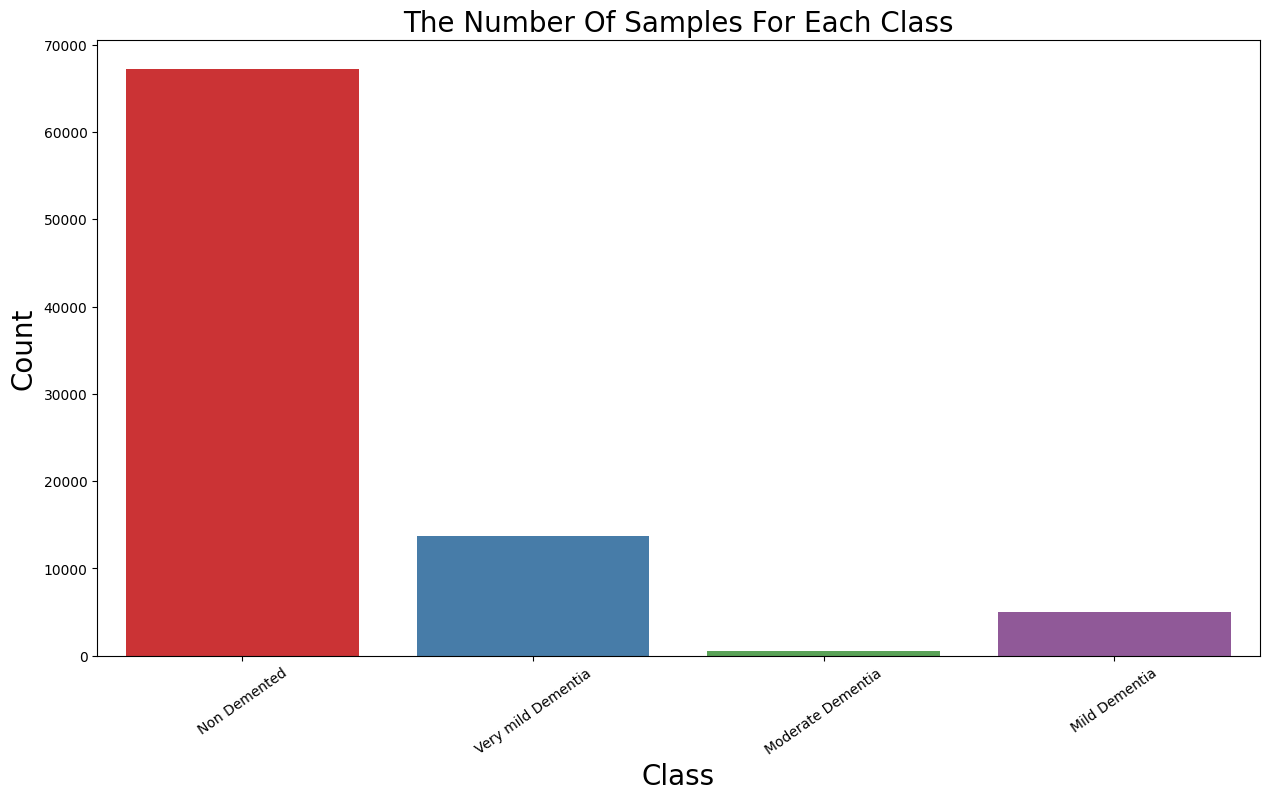

In [4]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(False)
plt.xticks(rotation=35)
plt.show()

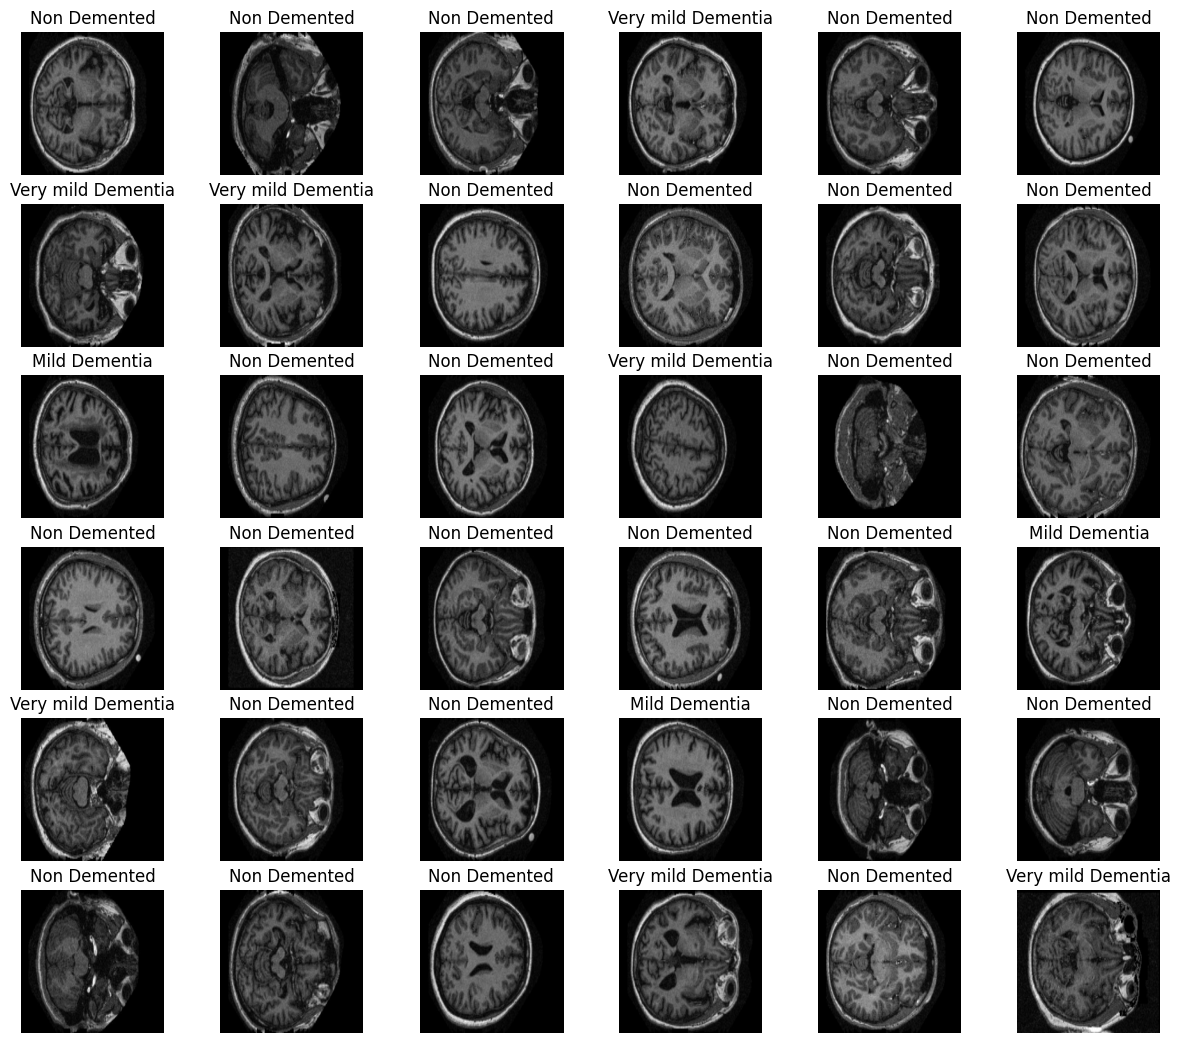

In [5]:
import random
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(15,13))
num = 36

for n, i in enumerate(random.sample(range(len(df)), num)):
    plt.subplot(6,6, n + 1)
    img = cv2.imread(df.image[i])
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i], fontsize=12)

plt.show() 

In [6]:
print(len(non_demented))
print(len(mild_demented))
print(len(moderate_demented))
print(len(very_mild_demented))

67222
5002
488
13725


In [7]:
encoder= OneHotEncoder()
encoder.fit([[0],[1],[2],[3]])

OneHotEncoder()

In [8]:
data = []
result = []
for s in non_demented:
    img = Image.open(s)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())
        
for s in mild_demented:
    img = Image.open(s)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())
        
for s in moderate_demented:
    img = Image.open(s)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[2]]).toarray())

for s in very_mild_demented:
    img = Image.open(s)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[3]]).toarray())

In [10]:
X=np.array(data)

In [11]:
print(X.shape)

(86437, 128, 128, 3)


In [12]:
y=np.array(result)
print(y.shape)

(86437, 1, 4)


In [13]:
y=y.reshape(86437,4)
y=np.argmax(y, axis=1)
y

array([0, 0, 0, ..., 3, 3, 3])

In [14]:
y.shape

(86437,)

In [15]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=42, shuffle = True)

In [16]:
base_model = EfficientNetV2B1(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)


28456008/28456008 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [17]:
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 64, 64,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 64, 64,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 64, 64,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 64, 64,    │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 64, 64,    │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 64, 64,    │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 64, 64,    │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 32, 32,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 32, 32,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 32, 32,    │          0 │ block2a_expand_b

 Total params: 17,549,752 (66.95 MB)

 Trainable params: 10,618,628 (40.51 MB)

 Non-trainable params: 6,931,124 (26.44 MB)

None


In [18]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(
    monitor='val_loss', patience=7, restore_best_weights=True
)


In [19]:

history = model.fit(X_train, y_train, validation_split=0.2, epochs=30,
                    batch_size=64, callbacks=[early_stopping])


Epoch 1/30


I0000 00:00:1744527007.036098     108 service.cc:145] XLA service 0x7f4e000036d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744527007.036157     108 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  6/865 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.4748 - loss: 4.1603  

I0000 00:00:1744527047.808588     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


865/865 ━━━━━━━━━━━━━━━━━━━━ 126s 84ms/step - accuracy: 0.7447 - loss: 0.9520 - val_accuracy: 0.8143 - val_loss: 0.4270
Epoch 2/30
865/865 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.7927 - loss: 0.4906 - val_accuracy: 0.8458 - val_loss: 0.3779
Epoch 3/30
865/865 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.8082 - loss: 0.4407 - val_accuracy: 0.8610 - val_loss: 0.3366
Epoch 4/30
865/865 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.8206 - loss: 0.4061 - val_accuracy: 0.8756 - val_loss: 0.2920
Epoch 5/30
865/865 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - accuracy: 0.8243 - loss: 0.3918 - val_accuracy: 0.8836 - val_loss: 0.2905
Epoch 6/30
865/865 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - accuracy: 0.8457 - loss: 0.3542 - val_accuracy: 0.9046 - val_loss: 0.2469
Epoch 7/30
865/865 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - accuracy: 0.8514 - loss: 0.3377 - val_accuracy: 0.9252 - val_loss: 0.2352
Epoch 8/30
865/865 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - accuracy: 0.8577 - loss: 0.3261 - val_accura

In [20]:
model.evaluate(X_test, y_test)

541/541 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.9690 - loss: 0.1107


[0.1134726032614708, 0.9665663838386536]

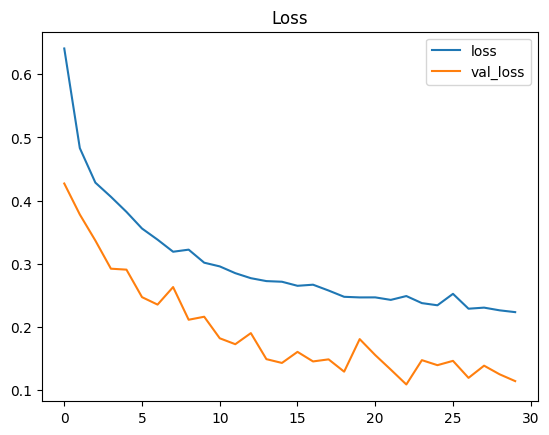

In [21]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
plt.title('Loss')
plt.show()


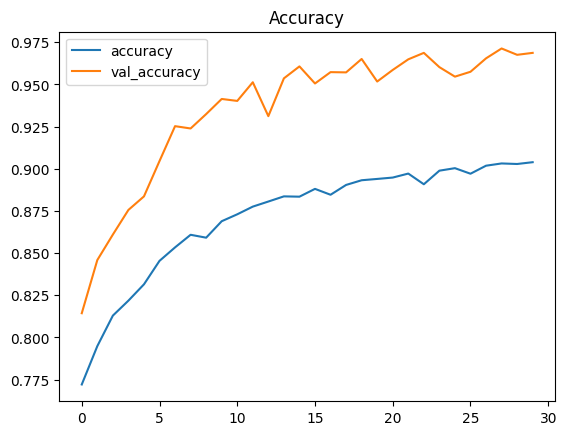

In [22]:
history_df[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy')
plt.show()


In [23]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


541/541 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step
Accuracy Score: 0.9665664044423878
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     13476
           1       0.99      0.77      0.87      1006
           2       0.00      0.00      0.00        97
           3       0.86      0.95      0.90      2709

    accuracy                           0.97     17288
   macro avg       0.71      0.68      0.69     17288
weighted avg       0.96      0.97      0.96     17288



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


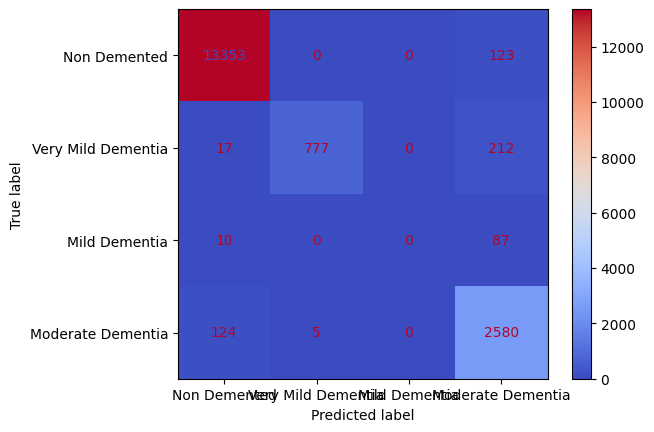

In [24]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=[
    "Non Demented", "Very Mild Dementia", "Mild Dementia", "Moderate Dementia"])
disp.plot(cmap='coolwarm')
plt.show()

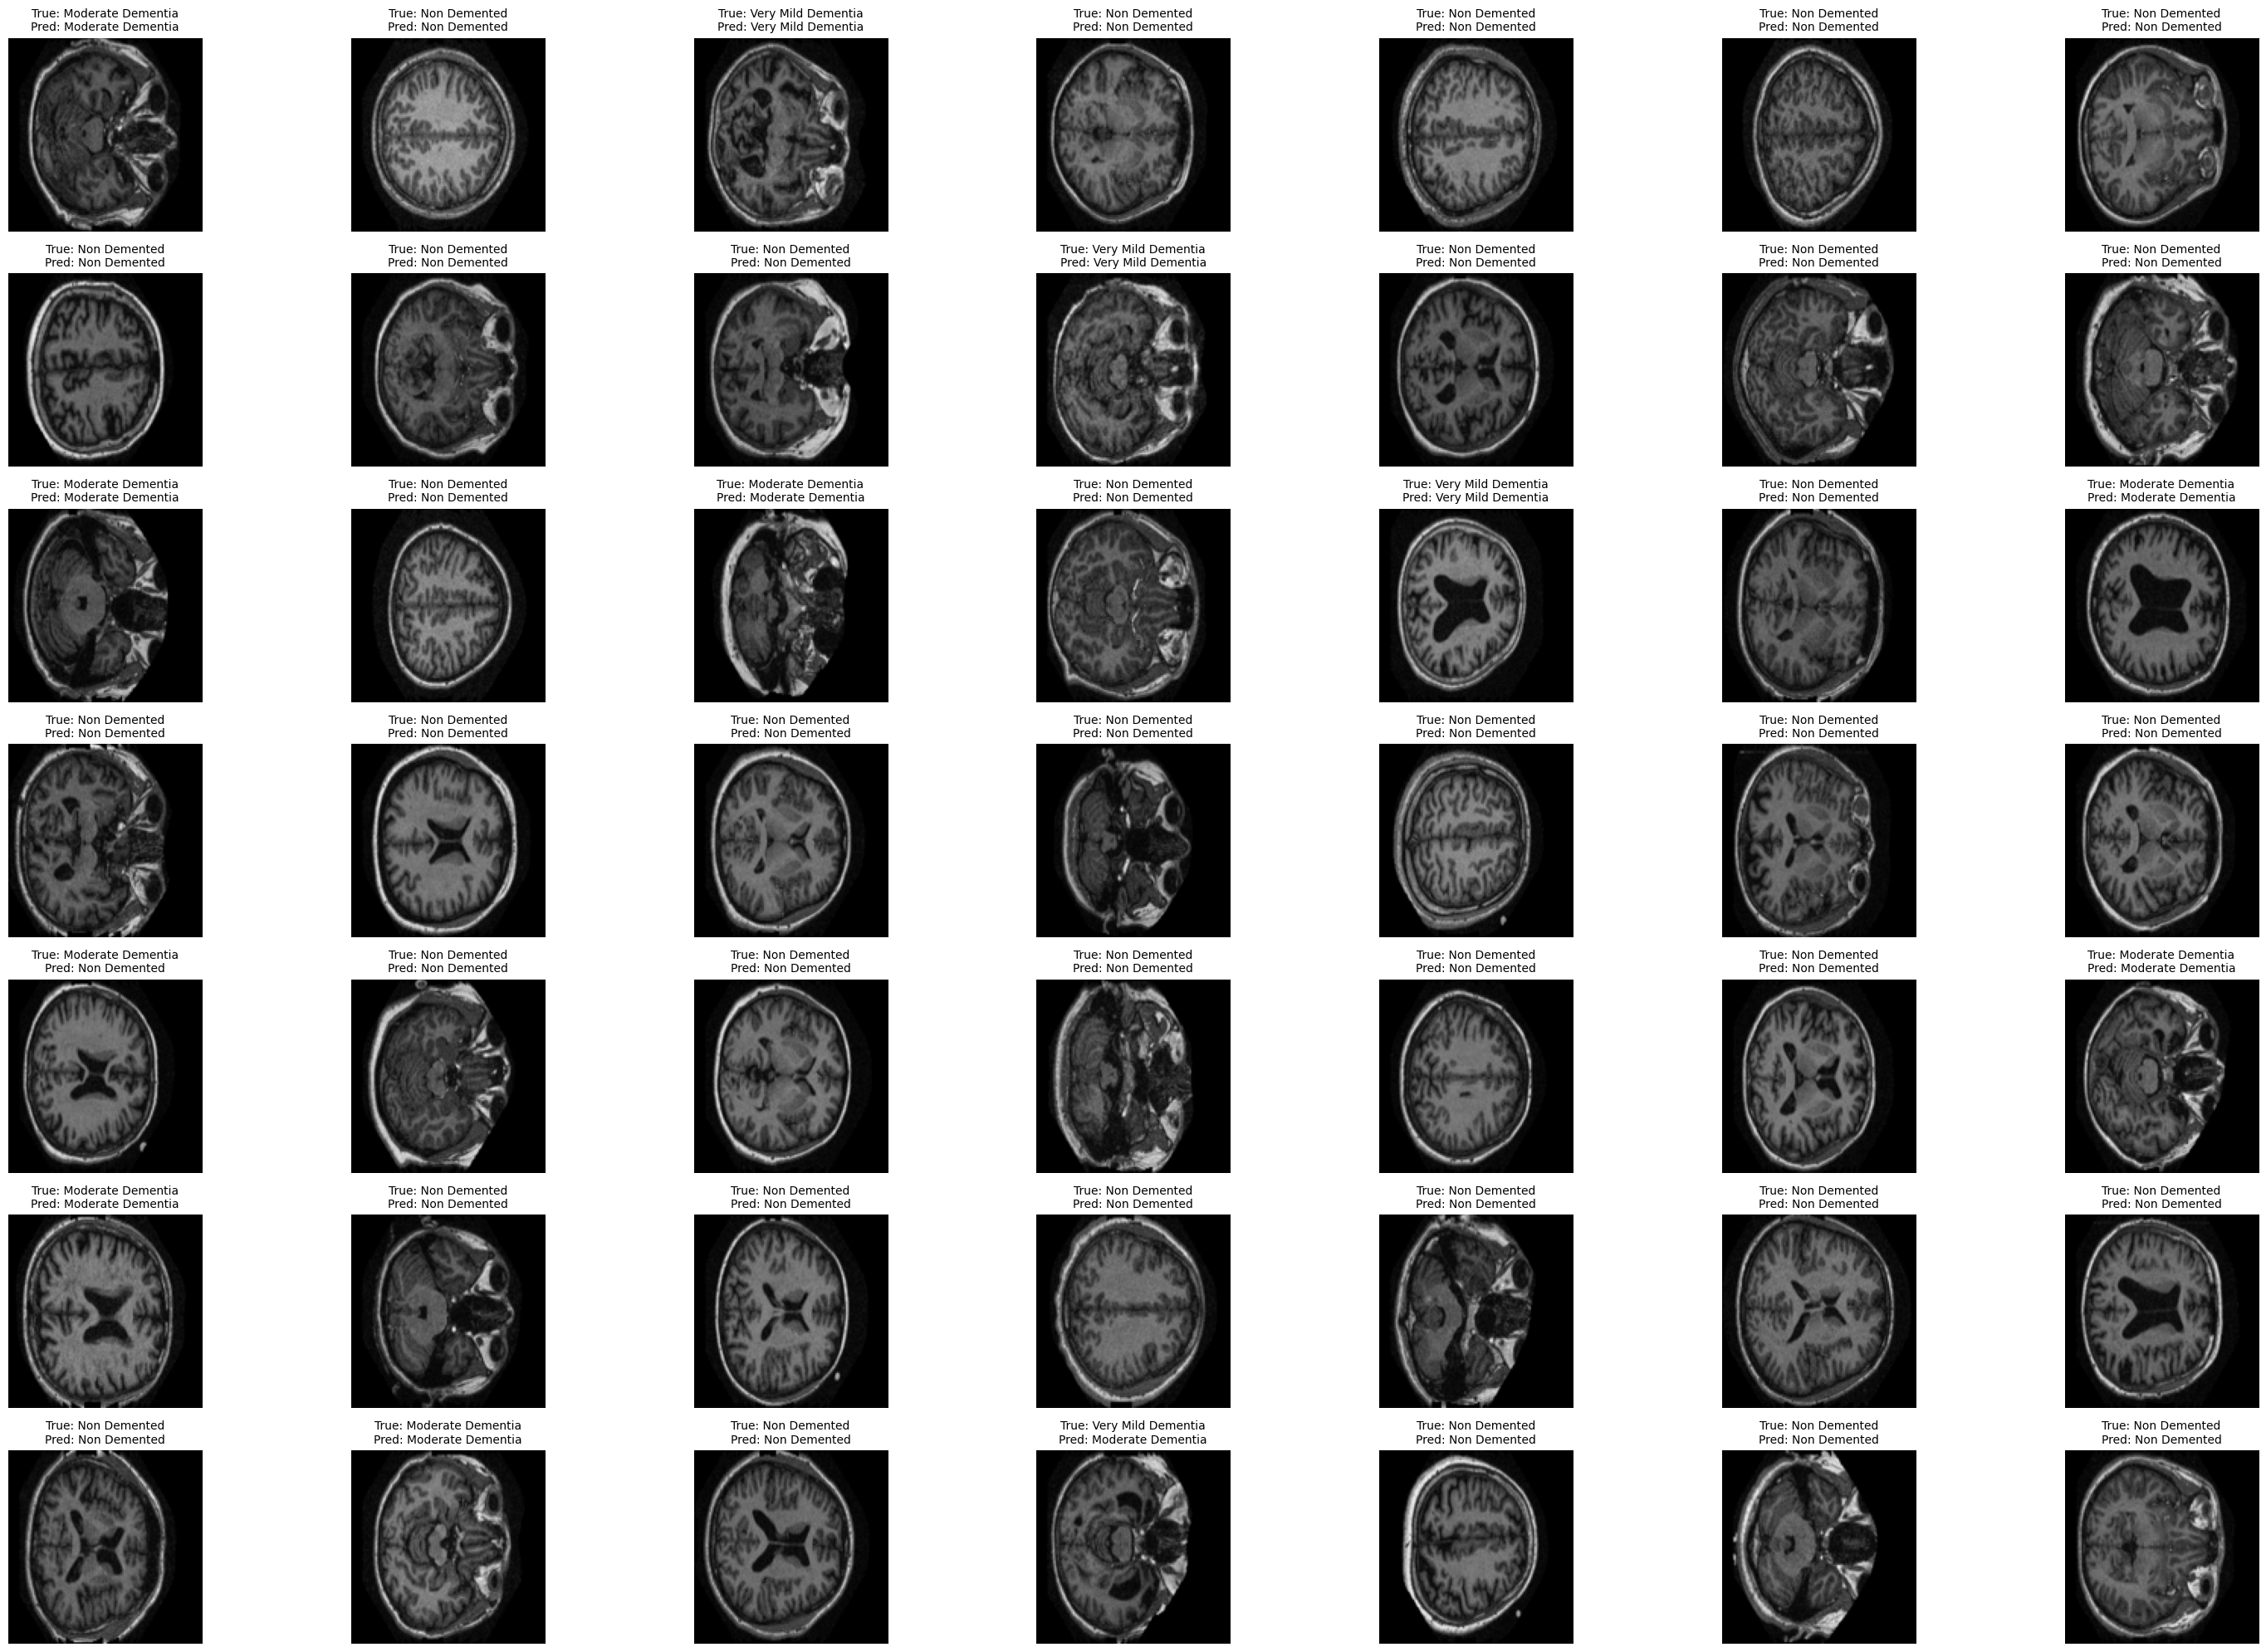

In [25]:
class_names = ["Non Demented", "Very Mild Dementia", "Mild Dementia", "Moderate Dementia"]
indices = np.random.choice(len(X_test), 49, replace=False)

plt.figure(figsize=(30, 20))
for i, idx in enumerate(indices):
    plt.subplot(7, 7, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"True: {class_names[y_test[idx]]}\nPred: {class_names[y_pred[idx]]}", fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

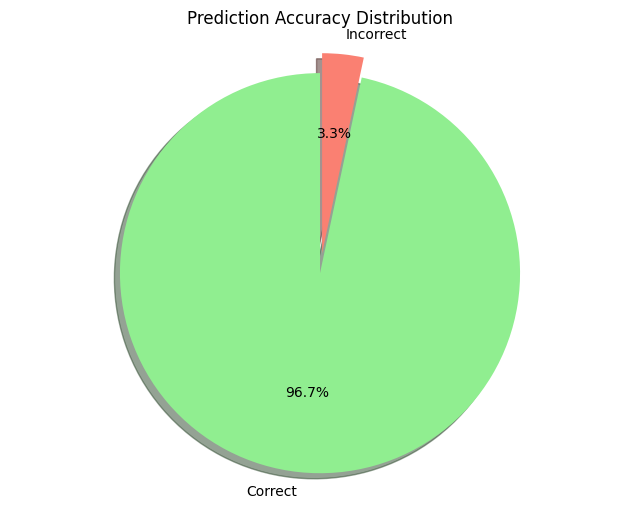

In [26]:
correct_predictions = np.sum(y_test == y_pred)
incorrect_predictions = np.sum(y_test != y_pred)

plt.figure(figsize=(8, 6))
plt.pie([correct_predictions, incorrect_predictions], explode=(0.1, 0), labels=['Correct', 'Incorrect'],
        colors=['lightgreen', 'salmon'], autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('Prediction Accuracy Distribution')
plt.show()

In [27]:

print("Correct Predictions:", correct_predictions)
print("Incorrect Predictions:", incorrect_predictions)

Correct Predictions: 16710
Incorrect Predictions: 578


In [28]:
from sklearn.model_selection import train_test_split

# Randomly sample 20% of training data as validation
X_train_check, X_val_check, y_train_check, y_val_check = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, shuffle=True)


In [29]:
model.evaluate(X_val_check, y_val_check)


433/433 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9698 - loss: 0.1056


[0.10366200655698776, 0.9705712199211121]